In [2]:
# Import librerie
import numpy as np
import pandas as pd
import json
from scipy import stats, interpolate
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Stile plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')



## 1. Caricamento Parametri Modello

In [3]:
# Carica parametri del modello
with open('../models/gamlss_model_params.json', 'r') as f:
    model_params = json.load(f)

# Carica lookup table (metodo principale per predizioni)
lookup_table = pd.read_csv('../models/gamlss_lookup_table.csv')

# Carica dati training per validazione
training_data = pd.read_csv('../models/gamlss_training_data_with_predictions.csv')

print("=" * 60)
print("MODELLO NORMATIVO CARICATO")
print("=" * 60)
print(f"Tipo: {model_params['model_info']['type']} con famiglia {model_params['model_info']['family']}")
print(f"Formula μ: {model_params['model_info']['formula_mu']}")
print(f"Formula σ: {model_params['model_info']['formula_sigma']}")
print(f"N soggetti training: {model_params['model_info']['n_subjects']}")
print(f"Range età: {model_params['model_info']['age_range']}")
print(f"Dataset: {model_params['model_info']['datasets']}")
print(f"\nLookup table: {len(lookup_table)} righe")
print(f"Training data: {len(training_data)} soggetti")

MODELLO NORMATIVO CARICATO
Tipo: GAMLSS con famiglia BCT
Formula μ: pb(age, df=3) + sex + dataset
Formula σ: age
N soggetti training: 2289
Range età: [45, 95]
Dataset: ['ADNI', 'IXI', 'OASIS2', 'OASIS3', 'PPMI', 'SRPBS']

Lookup table: 1212 righe
Training data: 2289 soggetti


## 2. Implementazione Distribuzione BCT

La distribuzione Box-Cox t (BCT) ha 4 parametri:
- μ (mu): parametro di posizione (mediana)
- σ (sigma): parametro di scala
- ν (nu): parametro di skewness (Box-Cox transformation)
- τ (tau): gradi di libertà (code della distribuzione)

In [4]:
class BCTDistribution:
    """
    Implementazione della distribuzione Box-Cox t (BCT) di GAMLSS.
    Riferimento: Rigby & Stasinopoulos (2005)
    """
    
    @staticmethod
    def _z_transform(y, mu, sigma, nu):
        """
        Trasformazione Box-Cox per ottenere z
        """
        if abs(nu) < 1e-10:  # nu ≈ 0 → log transform
            z = (1 / sigma) * np.log(y / mu)
        else:
            z = (1 / (sigma * nu)) * ((y / mu) ** nu - 1)
        return z
    
    @staticmethod
    def cdf(y, mu, sigma, nu, tau):
        """
        Funzione di distribuzione cumulativa (CDF) della BCT.
        Restituisce P(Y <= y).
        """
        z = BCTDistribution._z_transform(y, mu, sigma, nu)
        # La variabile z segue una distribuzione t con tau gradi di libertà
        p = stats.t.cdf(z, df=tau)
        return p
    
    @staticmethod
    def ppf(p, mu, sigma, nu, tau):
        """
        Funzione quantile (inversa della CDF).
        Dato p, restituisce y tale che P(Y <= y) = p.
        """
        z = stats.t.ppf(p, df=tau)
        if abs(nu) < 1e-10:
            y = mu * np.exp(sigma * z)
        else:
            y = mu * (1 + sigma * nu * z) ** (1 / nu)
        return y
    
    @staticmethod
    def zscore(y, mu, sigma, nu, tau):
        """
        Calcola lo z-score normalizzato.
        Converte il percentile BCT in z-score normale standard.
        """
        p = BCTDistribution.cdf(y, mu, sigma, nu, tau)
        # Gestione valori estremi
        p = np.clip(p, 1e-10, 1 - 1e-10)
        z = stats.norm.ppf(p)
        return z

# Test con dati training
test_idx = 0
test_row = training_data.iloc[test_idx]
z_calc = BCTDistribution.zscore(
    test_row['vol_total_hippocampus_norm'],
    test_row['fitted_mu'],
    test_row['fitted_sigma'],
    test_row['fitted_nu'],
    test_row['fitted_tau']
)
print(f"Test validazione z-score:")
print(f"  Z calcolato da R:      {test_row['z_score']:.4f}")
print(f"  Z calcolato da Python: {z_calc:.4f}")
print(f"  Differenza: {abs(test_row['z_score'] - z_calc):.6f}")
print("\n✓ Distribuzione BCT implementata correttamente!")

Test validazione z-score:
  Z calcolato da R:      -0.8409
  Z calcolato da Python: -0.8409
  Differenza: 0.000000

✓ Distribuzione BCT implementata correttamente!


## 3. Classe Modello Normativo

In [5]:
class HippocampalNormativeModel:
    """
    Modello normativo per volume ippocampale basato su GAMLSS BCT.
    Usa interpolazione dalla lookup table per predizioni.
    """
    
    def __init__(self, lookup_path: str, params_path: str = None):
        """
        Inizializza il modello caricando la lookup table.
        
        Args:
            lookup_path: Path al file CSV con la lookup table
            params_path: Path al file JSON con parametri (opzionale)
        """
        self.lookup = pd.read_csv(lookup_path)
        self.params = None
        if params_path:
            with open(params_path, 'r') as f:
                self.params = json.load(f)
        
        # Crea interpolatori per ogni combinazione sex/dataset
        self._build_interpolators()
        
    def _build_interpolators(self):
        """Costruisce interpolatori cubici per ogni gruppo."""
        self.interpolators = {}
        
        for sex in self.lookup['sex'].unique():
            for dataset in self.lookup['dataset'].unique():
                mask = (self.lookup['sex'] == sex) & (self.lookup['dataset'] == dataset)
                subset = self.lookup[mask].sort_values('age')
                
                if len(subset) > 3:  # Serve almeno qualche punto
                    key = (sex, dataset)
                    self.interpolators[key] = {
                        'mu': interpolate.interp1d(subset['age'], subset['mu'], 
                                                   kind='cubic', fill_value='extrapolate'),
                        'sigma': interpolate.interp1d(subset['age'], subset['sigma'], 
                                                      kind='cubic', fill_value='extrapolate'),
                        'nu': interpolate.interp1d(subset['age'], subset['nu'], 
                                                   kind='linear', fill_value='extrapolate'),
                        'tau': interpolate.interp1d(subset['age'], subset['tau'], 
                                                    kind='linear', fill_value='extrapolate')
                    }
        
        print(f"✓ Interpolatori creati per {len(self.interpolators)} combinazioni sex/dataset")
    
    def get_parameters(self, age: float, sex: str, dataset: str) -> dict:
        """
        Ottieni i parametri BCT predetti per un soggetto.
        
        Args:
            age: Età del soggetto
            sex: Sesso ('M' o 'F')
            dataset: Nome del dataset
            
        Returns:
            dict con mu, sigma, nu, tau
        """
        key = (sex, dataset)
        
        # Se il dataset non è nel training, usa la media dei dataset
        if key not in self.interpolators:
            # Fallback: usa stesso sesso ma primo dataset disponibile
            available = [k for k in self.interpolators.keys() if k[0] == sex]
            if available:
                key = available[0]
                print(f"  ⚠ Dataset '{dataset}' non trovato, usando '{key[1]}'")
            else:
                raise ValueError(f"Nessun interpolatore disponibile per sex='{sex}'")
        
        interp = self.interpolators[key]
        return {
            'mu': float(interp['mu'](age)),
            'sigma': float(interp['sigma'](age)),
            'nu': float(interp['nu'](age)),
            'tau': float(interp['tau'](age))
        }
    
    def compute_zscore(self, volume: float, age: float, sex: str, dataset: str) -> float:
        """
        Calcola lo z-score per un volume ippocampale osservato.
        
        Args:
            volume: Volume ippocampale normalizzato osservato
            age: Età del soggetto
            sex: Sesso ('M' o 'F')
            dataset: Nome del dataset
            
        Returns:
            Z-score (negativo = sotto la norma)
        """
        params = self.get_parameters(age, sex, dataset)
        z = BCTDistribution.zscore(volume, params['mu'], params['sigma'], 
                                    params['nu'], params['tau'])
        return z
    
    def compute_percentile(self, volume: float, age: float, sex: str, dataset: str) -> float:
        """
        Calcola il percentile per un volume ippocampale osservato.
        
        Returns:
            Percentile (0-100)
        """
        params = self.get_parameters(age, sex, dataset)
        p = BCTDistribution.cdf(volume, params['mu'], params['sigma'], 
                                 params['nu'], params['tau'])
        return p * 100
    
    def compute_centiles(self, age: float, sex: str, dataset: str, 
                         centiles: list = [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5]) -> dict:
        """
        Calcola i centili della distribuzione per dati demografici.
        
        Returns:
            dict con centile -> volume
        """
        params = self.get_parameters(age, sex, dataset)
        result = {}
        for c in centiles:
            result[c] = BCTDistribution.ppf(c/100, params['mu'], params['sigma'],
                                            params['nu'], params['tau'])
        return result
    
    def apply_to_dataframe(self, df: pd.DataFrame, 
                           volume_col: str = 'vol_total_hippocampus_norm',
                           age_col: str = 'age',
                           sex_col: str = 'sex',
                           dataset_col: str = 'dataset') -> pd.DataFrame:
        """
        Applica il modello a un DataFrame intero.
        
        Returns:
            DataFrame con colonne aggiunte: z_score, percentile, mu, sigma
        """
        df = df.copy()
        
        z_scores = []
        percentiles = []
        mus = []
        sigmas = []
        
        for idx, row in df.iterrows():
            try:
                params = self.get_parameters(row[age_col], row[sex_col], row[dataset_col])
                z = BCTDistribution.zscore(row[volume_col], params['mu'], params['sigma'],
                                           params['nu'], params['tau'])
                p = BCTDistribution.cdf(row[volume_col], params['mu'], params['sigma'],
                                        params['nu'], params['tau']) * 100
                z_scores.append(z)
                percentiles.append(p)
                mus.append(params['mu'])
                sigmas.append(params['sigma'])
            except Exception as e:
                z_scores.append(np.nan)
                percentiles.append(np.nan)
                mus.append(np.nan)
                sigmas.append(np.nan)
        
        df['z_score'] = z_scores
        df['percentile'] = percentiles
        df['predicted_mu'] = mus
        df['predicted_sigma'] = sigmas
        
        return df

# Inizializza il modello
model = HippocampalNormativeModel(
    lookup_path='../models/gamlss_lookup_table.csv',
    params_path='../models/gamlss_model_params.json'
)

print("\n✓ Modello normativo inizializzato!")

✓ Interpolatori creati per 12 combinazioni sex/dataset

✓ Modello normativo inizializzato!


## 4. Validazione su Dati Training

Validazione z-scores Python vs R...

VALIDAZIONE Z-SCORES: PYTHON vs R
Correlazione: 0.999895
MAE:          0.008799
Max diff:     0.137456

✅ VALIDAZIONE SUPERATA: Gli z-scores Python sono equivalenti a quelli R!
VALIDAZIONE Z-SCORES: PYTHON vs R
Correlazione: 0.999895
MAE:          0.008799
Max diff:     0.137456

✅ VALIDAZIONE SUPERATA: Gli z-scores Python sono equivalenti a quelli R!


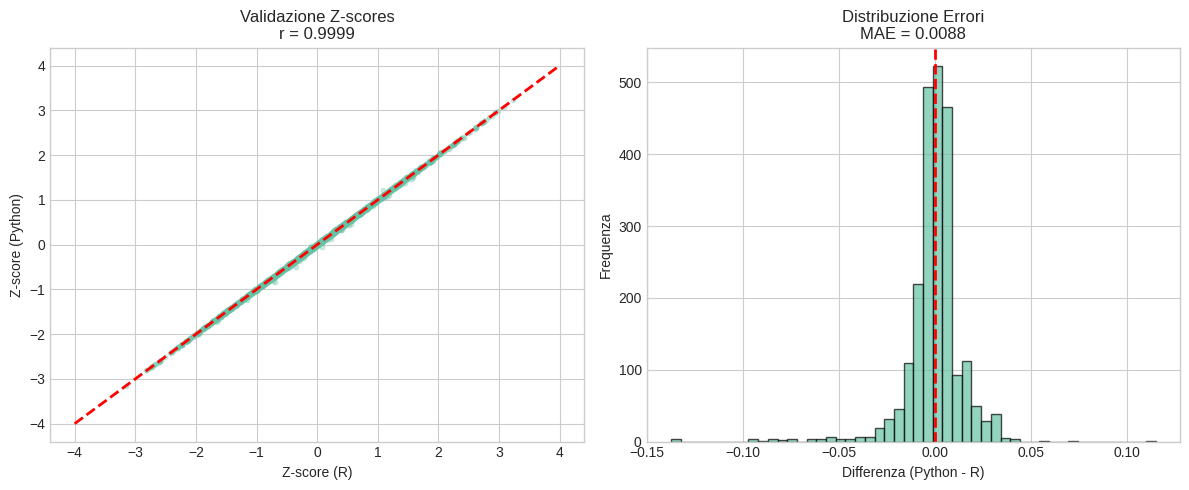

In [6]:
# Valida che gli z-score calcolati in Python corrispondano a quelli R
print("Validazione z-scores Python vs R...\n")

# Calcola z-score per tutti i soggetti training
training_validated = model.apply_to_dataframe(
    training_data,
    volume_col='vol_total_hippocampus_norm',
    age_col='age',
    sex_col='sex',
    dataset_col='dataset'
)

# Confronto
correlation = np.corrcoef(training_validated['z_score'], training_data['z_score'])[0, 1]
mae = np.mean(np.abs(training_validated['z_score'] - training_data['z_score']))
max_diff = np.max(np.abs(training_validated['z_score'] - training_data['z_score']))

print("=" * 60)
print("VALIDAZIONE Z-SCORES: PYTHON vs R")
print("=" * 60)
print(f"Correlazione: {correlation:.6f}")
print(f"MAE:          {mae:.6f}")
print(f"Max diff:     {max_diff:.6f}")

if correlation > 0.999 and mae < 0.01:
    print("\n✅ VALIDAZIONE SUPERATA: Gli z-scores Python sono equivalenti a quelli R!")
else:
    print("\n⚠️ ATTENZIONE: Ci sono differenze significative tra Python e R")

# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(training_data['z_score'], training_validated['z_score'], alpha=0.3, s=10)
axes[0].plot([-4, 4], [-4, 4], 'r--', lw=2)
axes[0].set_xlabel('Z-score (R)')
axes[0].set_ylabel('Z-score (Python)')
axes[0].set_title(f'Validazione Z-scores\nr = {correlation:.4f}')

diff = training_validated['z_score'] - training_data['z_score']
axes[1].hist(diff, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Differenza (Python - R)')
axes[1].set_ylabel('Frequenza')
axes[1].set_title(f'Distribuzione Errori\nMAE = {mae:.4f}')

plt.tight_layout()
plt.show()

## 5. Test su dati generati

In [7]:
# ============================================================
# ESEMPIO: Creazione dati sintetici per demo
# ============================================================
# Rimuovi questa cella quando hai dati reali

np.random.seed(42)

# Simula dati clinici basandosi sui dati training
n_per_group = 100

# Prendi subset dai dati training come CN
cn_sample = training_data.sample(n=n_per_group, random_state=42).copy()
cn_sample['diagnosis'] = 'CN'

# Simula MCI (volume ridotto del 10-15%)
mci_sample = training_data.sample(n=n_per_group, random_state=43).copy()
mci_sample['vol_total_hippocampus_norm'] *= np.random.uniform(0.85, 0.92, n_per_group)
mci_sample['diagnosis'] = 'MCI'

# Simula AD (volume ridotto del 20-30%)
ad_sample = training_data.sample(n=n_per_group, random_state=44).copy()
ad_sample['vol_total_hippocampus_norm'] *= np.random.uniform(0.70, 0.82, n_per_group)
ad_sample['diagnosis'] = 'AD'

# Combina
clinical_data = pd.concat([cn_sample, mci_sample, ad_sample], ignore_index=True)

print(f"\n⚠️ DATI SINTETICI DEMO (sostituisci con dati reali)")
print(f"\nDataset clinico creato:")
print(clinical_data['diagnosis'].value_counts())


⚠️ DATI SINTETICI DEMO (sostituisci con dati reali)

Dataset clinico creato:
diagnosis
CN     100
MCI    100
AD     100
Name: count, dtype: int64


## 6. Applicazione Modello ai Dati Clinici

In [8]:
# Applica il modello normativo ai dati clinici
clinical_with_zscores = model.apply_to_dataframe(
    clinical_data,
    volume_col='vol_total_hippocampus_norm'
)

print("=" * 60)
print("Z-SCORES PER GRUPPO DIAGNOSTICO")
print("=" * 60)

# Statistiche per gruppo
stats_by_group = clinical_with_zscores.groupby('diagnosis')['z_score'].agg(
    ['count', 'mean', 'std', 'median', 'min', 'max']
).round(3)

print(stats_by_group)

# Percentuale sotto soglia
print("\n" + "=" * 60)
print("PERCENTUALE SOTTO SOGLIA")
print("=" * 60)
for diag in ['CN', 'MCI', 'AD']:
    subset = clinical_with_zscores[clinical_with_zscores['diagnosis'] == diag]
    below_minus1 = (subset['z_score'] < -1).mean() * 100
    below_minus2 = (subset['z_score'] < -2).mean() * 100
    print(f"{diag}:  Z < -1: {below_minus1:5.1f}%   Z < -2: {below_minus2:5.1f}%")

Z-SCORES PER GRUPPO DIAGNOSTICO
           count   mean    std  median    min    max
diagnosis                                           
AD           100 -2.637  0.648  -2.727 -3.689 -0.724
CN           100  0.101  0.998   0.134 -1.969  2.635
MCI          100 -1.579  0.835  -1.568 -3.201  0.957

PERCENTUALE SOTTO SOGLIA
CN:  Z < -1:  18.0%   Z < -2:   0.0%
MCI:  Z < -1:  76.0%   Z < -2:  29.0%
AD:  Z < -1:  99.0%   Z < -2:  85.0%


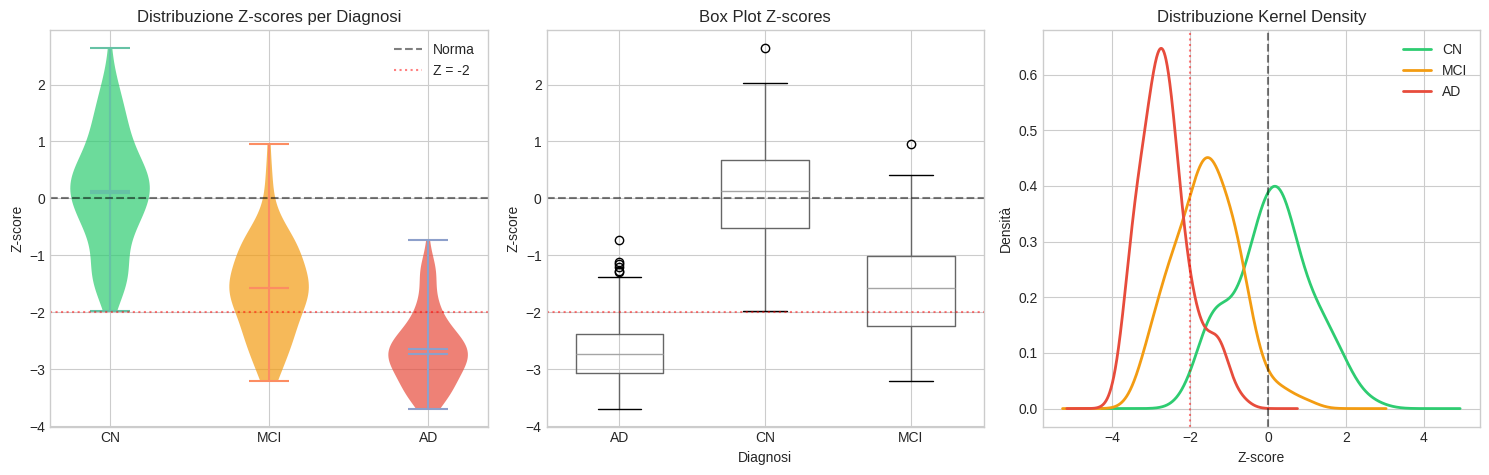


✓ Figura salvata in ../figures/gamlss/clinical_zscore_distribution.png


In [9]:
# Visualizzazione distribuzione z-scores per gruppo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'CN': '#2ecc71', 'MCI': '#f39c12', 'AD': '#e74c3c'}

# 1. Violin plot
ax1 = axes[0]
for i, diag in enumerate(['CN', 'MCI', 'AD']):
    data = clinical_with_zscores[clinical_with_zscores['diagnosis'] == diag]['z_score']
    vp = ax1.violinplot([data], positions=[i], showmeans=True, showmedians=True)
    vp['bodies'][0].set_facecolor(colors[diag])
    vp['bodies'][0].set_alpha(0.7)

ax1.axhline(0, color='black', linestyle='--', alpha=0.5, label='Norma')
ax1.axhline(-2, color='red', linestyle=':', alpha=0.5, label='Z = -2')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['CN', 'MCI', 'AD'])
ax1.set_ylabel('Z-score')
ax1.set_title('Distribuzione Z-scores per Diagnosi')
ax1.legend()

# 2. Box plot
ax2 = axes[1]
bp = clinical_with_zscores.boxplot(column='z_score', by='diagnosis', ax=ax2,
                                    positions=[0, 1, 2], widths=0.6)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(-2, color='red', linestyle=':', alpha=0.5)
ax2.set_xlabel('Diagnosi')
ax2.set_ylabel('Z-score')
ax2.set_title('Box Plot Z-scores')
plt.suptitle('')  # Rimuove titolo automatico

# 3. Density plot
ax3 = axes[2]
for diag in ['CN', 'MCI', 'AD']:
    data = clinical_with_zscores[clinical_with_zscores['diagnosis'] == diag]['z_score']
    data.plot(kind='kde', ax=ax3, label=diag, color=colors[diag], lw=2)

ax3.axvline(0, color='black', linestyle='--', alpha=0.5)
ax3.axvline(-2, color='red', linestyle=':', alpha=0.5)
ax3.set_xlabel('Z-score')
ax3.set_ylabel('Densità')
ax3.set_title('Distribuzione Kernel Density')
ax3.legend()

plt.tight_layout()
plt.savefig('../figures/gamlss/clinical_zscore_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Figura salvata in ../figures/gamlss/clinical_zscore_distribution.png")

## 7. Analisi ROC e Capacità Discriminativa

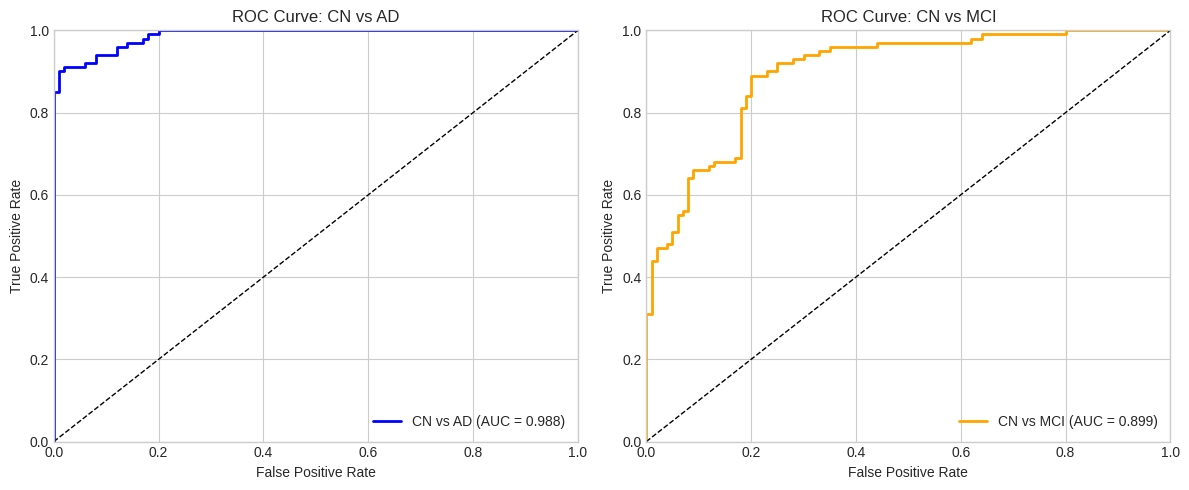


CAPACITÀ DISCRIMINATIVA
CN vs AD:  AUC = 0.988
CN vs MCI: AUC = 0.899

✓ ROC curves salvate in ../figures/gamlss/roc_curves_clinical.png


In [10]:
# ROC Analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Prepara dati per ROC
cn_data = clinical_with_zscores[clinical_with_zscores['diagnosis'] == 'CN']
mci_data = clinical_with_zscores[clinical_with_zscores['diagnosis'] == 'MCI']
ad_data = clinical_with_zscores[clinical_with_zscores['diagnosis'] == 'AD']

# ROC 1: CN vs AD
ax1 = axes[0]
y_true_ad = [0] * len(cn_data) + [1] * len(ad_data)
y_score_ad = list(-cn_data['z_score']) + list(-ad_data['z_score'])  # Negativo perché z basso = patologia

fpr_ad, tpr_ad, _ = roc_curve(y_true_ad, y_score_ad)
auc_ad = roc_auc_score(y_true_ad, y_score_ad)

ax1.plot(fpr_ad, tpr_ad, 'b-', lw=2, label=f'CN vs AD (AUC = {auc_ad:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve: CN vs AD')
ax1.legend(loc='lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# ROC 2: CN vs MCI
ax2 = axes[1]
y_true_mci = [0] * len(cn_data) + [1] * len(mci_data)
y_score_mci = list(-cn_data['z_score']) + list(-mci_data['z_score'])

fpr_mci, tpr_mci, _ = roc_curve(y_true_mci, y_score_mci)
auc_mci = roc_auc_score(y_true_mci, y_score_mci)

ax2.plot(fpr_mci, tpr_mci, 'orange', lw=2, label=f'CN vs MCI (AUC = {auc_mci:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve: CN vs MCI')
ax2.legend(loc='lower right')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../figures/gamlss/roc_curves_clinical.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("CAPACITÀ DISCRIMINATIVA")
print("=" * 60)
print(f"CN vs AD:  AUC = {auc_ad:.3f}")
print(f"CN vs MCI: AUC = {auc_mci:.3f}")
print("\n✓ ROC curves salvate in ../figures/gamlss/roc_curves_clinical.png")

## 8. Statistiche Inferenziali

In [11]:
from scipy.stats import mannwhitneyu, kruskal

print("=" * 60)
print("TEST STATISTICI")
print("=" * 60)

# Kruskal-Wallis (test non parametrico per 3+ gruppi)
stat_kw, p_kw = kruskal(
    cn_data['z_score'],
    mci_data['z_score'],
    ad_data['z_score']
)
print(f"\nKruskal-Wallis (CN vs MCI vs AD):")
print(f"  H = {stat_kw:.2f}, p = {p_kw:.2e}")

# Mann-Whitney pairwise
print(f"\nMann-Whitney U (confronti a coppie):")

stat, p = mannwhitneyu(cn_data['z_score'], ad_data['z_score'], alternative='greater')
print(f"  CN vs AD:  U = {stat:.0f}, p = {p:.2e}")

stat, p = mannwhitneyu(cn_data['z_score'], mci_data['z_score'], alternative='greater')
print(f"  CN vs MCI: U = {stat:.0f}, p = {p:.2e}")

stat, p = mannwhitneyu(mci_data['z_score'], ad_data['z_score'], alternative='greater')
print(f"  MCI vs AD: U = {stat:.0f}, p = {p:.2e}")

# Effect size (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

print(f"\nEffect Size (Cohen's d):")
d_cn_ad = cohens_d(cn_data['z_score'], ad_data['z_score'])
d_cn_mci = cohens_d(cn_data['z_score'], mci_data['z_score'])
d_mci_ad = cohens_d(mci_data['z_score'], ad_data['z_score'])

print(f"  CN vs AD:  d = {d_cn_ad:.2f} ({'large' if abs(d_cn_ad) > 0.8 else 'medium' if abs(d_cn_ad) > 0.5 else 'small'})")
print(f"  CN vs MCI: d = {d_cn_mci:.2f} ({'large' if abs(d_cn_mci) > 0.8 else 'medium' if abs(d_cn_mci) > 0.5 else 'small'})")
print(f"  MCI vs AD: d = {d_mci_ad:.2f} ({'large' if abs(d_mci_ad) > 0.8 else 'medium' if abs(d_mci_ad) > 0.5 else 'small'})")

TEST STATISTICI

Kruskal-Wallis (CN vs MCI vs AD):
  H = 195.83, p = 3.00e-43

Mann-Whitney U (confronti a coppie):
  CN vs AD:  U = 9878, p = 4.79e-33
  CN vs MCI: U = 8985, p = 1.06e-22
  MCI vs AD: U = 8396, p = 5.36e-17

Effect Size (Cohen's d):
  CN vs AD:  d = 3.25 (large)
  CN vs MCI: d = 1.83 (large)
  MCI vs AD: d = 1.42 (large)


## 9. Esempio: Applicazione a Singolo Soggetto

In [12]:
# Esempio pratico: valutazione di un singolo soggetto

def evaluate_subject(model, volume, age, sex, dataset):
    """
    Valuta un singolo soggetto rispetto al modello normativo.
    """
    z = model.compute_zscore(volume, age, sex, dataset)
    percentile = model.compute_percentile(volume, age, sex, dataset)
    centiles = model.compute_centiles(age, sex, dataset)
    
    print("=" * 60)
    print("VALUTAZIONE SOGGETTO")
    print("=" * 60)
    print(f"\nDati input:")
    print(f"  Età: {age} anni")
    print(f"  Sesso: {sex}")
    print(f"  Dataset: {dataset}")
    print(f"  Volume ippocampale: {volume:.6f}")
    
    print(f"\nRisultati:")
    print(f"  Z-score:    {z:.2f}")
    print(f"  Percentile: {percentile:.1f}°")
    
    # Interpretazione
    print(f"\nInterpretazione:")
    if z >= -1:
        print(f"  ✅ Volume nella NORMA (Z ≥ -1)")
    elif z >= -2:
        print(f"  ⚠️ Volume BORDERLINE (−2 < Z < −1)")
        print(f"     Consigliato follow-up")
    else:
        print(f"  ❌ Volume SOTTO LA NORMA (Z ≤ −2)")
        print(f"     Possibile atrofia ippocampale")
    
    print(f"\nCentili di riferimento per età {age}, sesso {sex}:")
    print(f"  5°:  {centiles[5]:.6f}")
    print(f"  50°: {centiles[50]:.6f}")
    print(f"  95°: {centiles[95]:.6f}")
    
    return z, percentile

# Esempio
print("\n" + "="*60)
print("ESEMPIO 1: Soggetto sano tipico")
evaluate_subject(model, volume=0.0045, age=70, sex='M', dataset='ADNI')

print("\n\n")
print("="*60)
print("ESEMPIO 2: Soggetto con possibile atrofia")
evaluate_subject(model, volume=0.0035, age=70, sex='M', dataset='ADNI')


ESEMPIO 1: Soggetto sano tipico
VALUTAZIONE SOGGETTO

Dati input:
  Età: 70 anni
  Sesso: M
  Dataset: ADNI
  Volume ippocampale: 0.004500

Risultati:
  Z-score:    -1.36
  Percentile: 8.7°

Interpretazione:
  ⚠️ Volume BORDERLINE (−2 < Z < −1)
     Consigliato follow-up

Centili di riferimento per età 70, sesso M:
  5°:  0.004361
  50°: 0.005088
  95°: 0.005762



ESEMPIO 2: Soggetto con possibile atrofia
VALUTAZIONE SOGGETTO

Dati input:
  Età: 70 anni
  Sesso: M
  Dataset: ADNI
  Volume ippocampale: 0.003500

Risultati:
  Z-score:    -3.09
  Percentile: 0.1°

Interpretazione:
  ❌ Volume SOTTO LA NORMA (Z ≤ −2)
     Possibile atrofia ippocampale

Centili di riferimento per età 70, sesso M:
  5°:  0.004361
  50°: 0.005088
  95°: 0.005762


(-3.0855830605768206, 0.1015767367723694)

## 10. Esportazione Risultati

In [13]:
# Salva risultati clinici
output_path = '../data/combined/clinical_subjects_with_zscores.csv'
clinical_with_zscores.to_csv(output_path, index=False)
print(f"✓ Risultati salvati in: {output_path}")

# Riepilogo
print("\n" + "=" * 60)
print("RIEPILOGO APPLICAZIONE CLINICA")
print("=" * 60)
print(f"\nSoggetti analizzati: {len(clinical_with_zscores)}")
print(f"\nDistribuzione diagnosi:")
print(clinical_with_zscores['diagnosis'].value_counts().to_string())
print(f"\nCapacità discriminativa:")
print(f"  AUC CN vs AD:  {auc_ad:.3f}")
print(f"  AUC CN vs MCI: {auc_mci:.3f}")
print(f"\nFile output:")
print(f"  - {output_path}")
print(f"  - ../figures/gamlss/clinical_zscore_distribution.png")
print(f"  - ../figures/gamlss/roc_curves_clinical.png")

✓ Risultati salvati in: ../data/combined/clinical_subjects_with_zscores.csv

RIEPILOGO APPLICAZIONE CLINICA

Soggetti analizzati: 300

Distribuzione diagnosi:
diagnosis
CN     100
MCI    100
AD     100

Capacità discriminativa:
  AUC CN vs AD:  0.988
  AUC CN vs MCI: 0.899

File output:
  - ../data/combined/clinical_subjects_with_zscores.csv
  - ../figures/gamlss/clinical_zscore_distribution.png
  - ../figures/gamlss/roc_curves_clinical.png


---

## Note Importanti

### Uso con Dati Reali

1. **Dataset di riferimento**: Se applichi il modello a dati da un dataset NON presente nel training, i risultati potrebbero essere meno accurati. Considera di:
   - Usare il dataset più simile come proxy
   - Ritrainare il modello includendo il nuovo dataset

2. **Preprocessing**: Assicurati che i volumi ippocampali siano normalizzati nello stesso modo (SynthSeg + normalizzazione per ICV/eTIV).

3. **Range età**: Il modello è stato trainato su soggetti 45-95 anni. Usalo con cautela fuori da questo range.

### Interpretazione Clinica

- **Z < -2**: Indica volume significativamente sotto la norma (< 2.5° percentile)
- **-2 < Z < -1**: Zona borderline, suggerisce monitoring
- **Z ≥ -1**: Volume nella norma

Il modello normativo fornisce una **valutazione quantitativa individualizzata** che considera età, sesso e variabilità inter-dataset.